## Packages

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Data Pre-processing

In [2]:
df = pd.read_csv('data_minute.csv')
df = df.iloc[:,1:]
df.columns = ['date', 'symbol','open', 'high', 'low', 'close', 'vol(btc)', 'vol']
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by = ['date'], ascending=True)
df.index = pd.to_datetime(df['date'])
df.drop(["date", 'symbol', 'vol(btc)'], axis=1, inplace=True)
df

,open,high,low,close,vol
date,,,,,
2015-10-08 13:40:00,0.00,242.50,0.00,242.50,12.125000
2015-10-08 13:41:00,242.50,242.95,242.50,242.95,0.242950
2015-10-08 13:42:00,242.95,242.95,242.95,242.95,0.000000
2015-10-08 13:43:00,242.95,242.96,242.95,242.96,2.429600
2015-10-08 13:44:00,242.96,242.96,242.96,242.96,8.137003
...,...,...,...,...,...
2023-02-21 00:29:00,24809.27,24812.25,24809.27,24812.25,2249.862431
2023-02-21 00:30:00,24812.25,24818.09,24812.25,24818.09,54.681450
2023-02-21 00:31:00,24818.09,24821.96,24815.47,24821.96,2249.866178


In [3]:
# Prepare the volume and price differences, normalize volume
BTC_vol = df["vol"].values
df_diff = df.diff().dropna() # difference of df
df_diff["vol"] = np.log(1 + BTC_vol[:-1])  # Shifted by 1 to align with diff
df_aligned = df.loc[df_diff.index]
mask_train = (df_diff.index >= "2021-10-01") & (df_diff.index < "2021-12-30")
df_train = df_diff.loc[mask_train].copy()
# Use df_aligned to ensure the indexes match
train_close = df_aligned.loc[mask_train, "close"].values

# Since indexes are aligned, this operation should now work without error
df_train["Relative_Close"] = train_close / train_close[0]

df_train

,open,high,low,close,vol,Relative_Close
date,,,,,,
2021-10-01 00:00:00,49.39,0.00,35.28,0.00,9.019722,1.000000
2021-10-01 00:01:00,0.00,43.23,14.11,41.79,8.779245,1.000953
2021-10-01 00:02:00,41.79,85.12,-27.83,86.56,11.237755,1.002928
2021-10-01 00:03:00,86.56,16.26,127.39,14.35,12.853947,1.003256
2021-10-01 00:04:00,14.35,12.35,24.08,14.26,11.558565,1.003581
...,...,...,...,...,...,...
2021-12-29 23:55:00,-62.86,42.86,-3.64,58.71,10.324764,1.058745
2021-12-29 23:56:00,58.71,29.40,62.21,60.39,12.908310,1.060123
2021-12-29 23:57:00,60.39,-9.44,28.43,16.70,12.041826,1.060504


In [4]:
mask_test = (df_diff.index >= "2021-12-31") & (df_diff.index < "2022-01-01")  # December 2018 for testing
df_test = df_diff.loc[mask_test].copy()
test_close = df_aligned.loc[mask_test, "close"].values
df_test["Relative_Close"] = test_close / train_close[0]
df_test

,open,high,low,close,vol,Relative_Close
date,,,,,,
2021-12-31 00:00:00,-8.94,-23.58,-30.65,-30.65,8.592966,1.074458
2021-12-31 00:01:00,-30.65,67.03,0.00,95.45,7.446695,1.076636
2021-12-31 00:02:00,95.45,76.63,88.21,72.93,8.408928,1.078300
2021-12-31 00:03:00,72.93,19.19,27.12,-53.05,11.121081,1.077090
2021-12-31 00:04:00,-53.05,-58.71,-2.89,19.46,10.819536,1.077534
...,...,...,...,...,...,...
2021-12-31 23:55:00,-33.08,-30.82,-15.34,-27.82,9.829861,1.055273
2021-12-31 23:56:00,-27.82,0.00,-5.53,24.21,9.723314,1.055826
2021-12-31 23:57:00,24.21,-5.87,-3.21,-29.88,10.579423,1.055144


### Generate LSTM Dataset 

In [17]:
# Generate dataset function for LSTM
def generate_dataset_LSTM(df, seq_len):
    X_list, y_list = [], []
    for i in range(len(df) - seq_len):
        X_list.append(df.iloc[i:(i+seq_len), :].values)
        y_list.append(df["close"].iloc[i + seq_len])
    return np.array(X_list), np.array(y_list)

In [18]:
LAG = 5 # Example: Use the past # days to predict the next day
# Prepare training and test datasets
X_train_LSTM, y_train_LSTM = generate_dataset_LSTM(df_train, LAG)
X_test_LSTM, y_test_LSTM = generate_dataset_LSTM(pd.concat((df_train.iloc[-LAG:], df_test)), LAG)

In [19]:
X_train_LSTM.shape

(129595, 5, 6)

## LSTM (unchanged from minute-by-minute example)

In [21]:
# model architecture
tf.keras.utils.set_random_seed(4012)
model = Sequential([
    LSTM(8, return_sequences=True, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])),
    LSTM(8, dropout=0.2),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# train the dataset
model.fit(X_train_LSTM, y_train_LSTM, batch_size=64, epochs=30, shuffle=True) 

Epoch 1/30


2025/2025 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 2894.7766
Epoch 2/30
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 2894.6125
Epoch 3/30
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 2894.2544
Epoch 4/30
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 2894.1660
Epoch 5/30
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 2894.1304
Epoch 6/30
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 2893.7859
Epoch 7/30
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 2893.5754
Epoch 8/30
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 2893.3203
Epoch 9/30
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 2892.9104
Epoch 10/30
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 2892.5425
Epoch 11/30
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 2892.7134
Epoch 12/30
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 2893.6616
Epoch 13/30
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 2892.3247
Epoch 14/30
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 2892.547

In [22]:
# Predict and evaluate
pred_LSTM = np.squeeze(model.predict(X_test_LSTM))
print("Test MSE:", np.mean((pred_LSTM - y_test_LSTM)**2))

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step
Test MSE: 1447.1916771248484


In [23]:
pred_LSTM, y_test_LSTM

(array([ 0.835104  , -1.4218806 ,  0.00751573, ...,  1.905922  ,
        -1.6762354 , -2.1692884 ], dtype=float32),
 array([-30.65,  95.45,  72.93, ..., -29.88, -56.66,  29.61]))

## MLP

In [5]:
X_train_MLP = df_train[['open'	,'high'	,'low'	,'vol',	'Relative_Close']]
y_train_MLP = df_train[['close']]
X_test_MLP = df_test[['open'	,'high'	,'low'	,'vol',	'Relative_Close']]
y_test_MLP = df_test[['close']]

In [25]:
# # Min-Max Scaling
# scaler = MinMaxScaler()
# data_train = scaler.fit_transform(df_train[['open','high'	,'low'	,'vol',	'Relative_Close', 'close']])
# data_test = scaler.fit_transform(df_test[['open','high','low'	,'vol',	'Relative_Close', 'close']])
# df_train_MLP = pd.DataFrame(data_train, columns=['open','high','low'	,'vol',	'Relative_Close', 'close'], index=df_train.index)
# df_test_MLP = pd.DataFrame(data_test, columns=['open','high','low'	,'vol',	'Relative_Close', 'close'], index=df_test.index)

In [26]:
# X_train_MLP = df_train_MLP[['open'	,'high'	,'low'	,'vol',	'Relative_Close']]
# y_train_MLP = df_train_MLP[['close']]
# X_test_MLP = df_test_MLP[['open','high'	,'low'	,'vol',	'Relative_Close']]
# y_test_MLP = df_test_MLP[['close']]

In [27]:
X_train_MLP.shape

(129600, 5)

In [28]:
# model architecture for MLP: 1 64-nueron layer and 1 Dropout
tf.keras.utils.set_random_seed(4012)
model2 = Sequential()
model2.add(tf.keras.Input(shape=(X_train_MLP.shape[1],))) # input features
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1))

model2.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model2.fit(X_train_MLP, y_train_MLP, batch_size=64, epochs=100, shuffle=True)

Epoch 1/100


2025/2025 ━━━━━━━━━━━━━━━━━━━━ 1s 387us/step - loss: 1502.4392
Epoch 2/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 1s 382us/step - loss: 851.7139
Epoch 3/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 1s 367us/step - loss: 821.0431
Epoch 4/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 1s 369us/step - loss: 804.3356
Epoch 5/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 1s 368us/step - loss: 814.1101
Epoch 6/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 1s 392us/step - loss: 775.9545
Epoch 7/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 1s 364us/step - loss: 795.4180
Epoch 8/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 1s 379us/step - loss: 800.9208
Epoch 9/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 1s 362us/step - loss: 761.3831
Epoch 10/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 1s 373us/step - loss: 774.6706
Epoch 11/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 1s 371us/step - loss: 760.8271
Epoch 12/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 1s 369us/step - loss: 757.8733
Epoch 13/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 1s 379us/step - loss: 736.5706
Epoch 14/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 1

In [29]:
pred_MLP = model2.predict(X_test_MLP)
pred_MLP

 1/45 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step


array([[-24.152346],
       [ 75.757545],
       [ 39.12698 ],
       ...,
       [-18.133734],
       [-59.531136],
       [ 28.320278]], dtype=float32)

In [30]:
# # Model Pred rescale
# scaled_pred_MLP = model2.predict(X_test_MLP)
# scaled_pred_MLP_reshaped = np.zeros((scaled_pred_MLP.shape[0], df_test.shape[1]))
# scaled_pred_MLP_reshaped[:, 0] = scaled_pred_MLP[:, 0]  # Assuming the first column is the predicted closing price
# pred_MLP_reshaped = scaler.inverse_transform(scaled_pred_MLP_reshaped) # Apply inverse transformation
# pred_MLP = pred_MLP_reshaped[:, 0]
# pred_MLP

In [31]:
# # y_test_MLP rescale
# scaled_actual_MLP_reshaped = np.zeros((scaled_pred_MLP.shape[0], df_test.shape[1]))
# scaled_actual_MLP_reshaped[:, 0] = y_test_MLP['close']  # Assuming the first column is the predicted closing price
# actual_MLP_reshaped = scaler.inverse_transform(scaled_actual_MLP_reshaped) # Apply inverse transformation
# actual_MLP = actual_MLP_reshaped[:, 0]
# actual_MLP

In [32]:
mse = tf.keras.losses.MeanSquaredError()
mse_MLP = mse(y_test_MLP, pred_MLP)
mse_LSTM = mse(y_test_LSTM, pred_LSTM)
mse_MLP, mse_LSTM

(<tf.Tensor: shape=(), dtype=float32, numpy=361.107>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1447.1918>)

In [33]:
np.array(df_test.index)

array(['2021-12-31T00:00:00.000000000', '2021-12-31T00:01:00.000000000',
       '2021-12-31T00:02:00.000000000', ...,
       '2021-12-31T23:57:00.000000000', '2021-12-31T23:58:00.000000000',
       '2021-12-31T23:59:00.000000000'], dtype='datetime64[ns]')

Text(0, 0.5, 'Difference in Price')

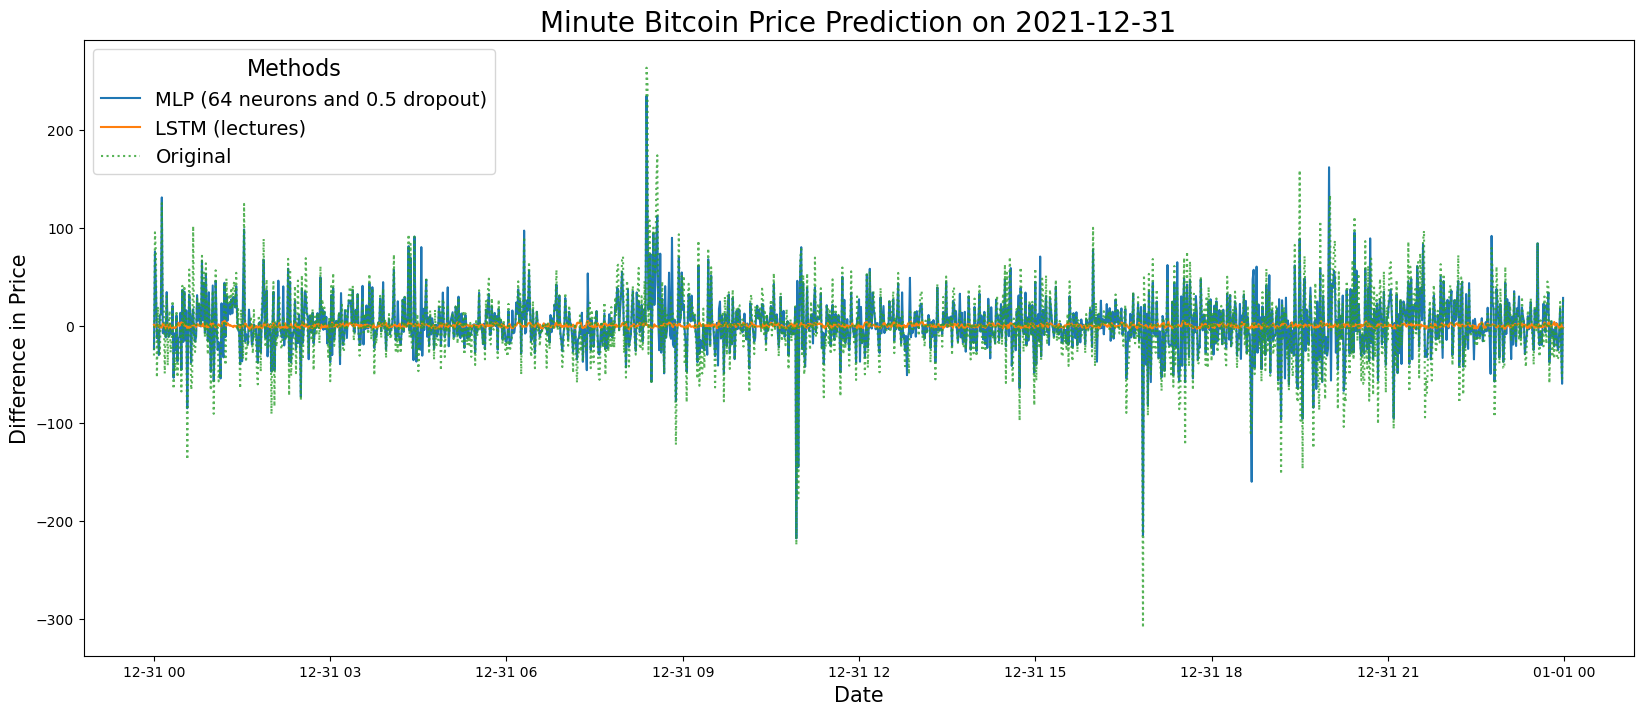

In [36]:
fig = plt.figure(figsize=(20,8))
plt.plot(np.array(df_test.index), pred_MLP, label='MLP (64 neurons and 0.5 dropout)')
plt.plot(np.array(df_test.index), pred_LSTM, label='LSTM (lectures)')
plt.plot(np.array(df_test.index), df_test["close"], label='Original', linestyle='dotted', alpha=0.8)
plt.legend(title='Methods',title_fontsize=16, fontsize=14)
plt.title('Minute Bitcoin Price Prediction on 2021-12-31', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Difference in Price', fontsize=15)

### Test on MLP Models

#### 1. Number of Hidden Layers & Activation Functions

In [9]:
def build_model(num_layers,act_fcn, train_df = X_train_MLP):
    # tf.keras.backend.clear_session()
    tf.keras.utils.set_random_seed(4012)
    
    model = Sequential()
    model.add(tf.keras.Input(shape=(train_df.shape[1],)))
    model.add(Dense(64, activation=act_fcn))
    
    for _ in range(num_layers):
        model.add(Dense(64, activation=act_fcn))

    # model.add(Dropout(0.5))
    model.add(Dense(1))
    return model

num_layers_list = [0, 1, 2, 3]  
activation_fcns = ['relu','sigmoid']
mse = tf.keras.losses.MeanSquaredError()
mae = tf.keras.losses.MeanAbsoluteError()
no_lay_df = pd.DataFrame(columns = ['No_layers','Act_Fcns','MSE','MAE'])

for num_layers in num_layers_list:
    for act_fcn in activation_fcns:
        model = build_model(num_layers, act_fcn)
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

        model.fit(X_train_MLP, y_train_MLP, batch_size=64, epochs=100, shuffle=True)
        pred_MLP = model.predict(X_test_MLP)
        mse_MLP = mse(y_test_MLP, pred_MLP).numpy()
        mae_MLP = mae(y_test_MLP, pred_MLP).numpy()

        no_lay_df_new = pd.DataFrame(dict(No_layers=[num_layers+1], Act_Fcns=[act_fcn],MSE=[mse_MLP],MAE=[mae_MLP]))
        no_lay_df = pd.concat([no_lay_df, no_lay_df_new], axis=0, ignore_index=True)


Epoch 1/100


2025/2025 ━━━━━━━━━━━━━━━━━━━━ 1s 361us/step - accuracy: 0.0193 - loss: 1035.1670
Epoch 2/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 1s 367us/step - accuracy: 0.0216 - loss: 694.9020
Epoch 3/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 1s 363us/step - accuracy: 0.0212 - loss: 671.8465
Epoch 4/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 1s 358us/step - accuracy: 0.0212 - loss: 661.8739
Epoch 5/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 1s 397us/step - accuracy: 0.0211 - loss: 656.7061
Epoch 6/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 1s 427us/step - accuracy: 0.0210 - loss: 652.6867
Epoch 7/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 1s 423us/step - accuracy: 0.0210 - loss: 649.0777
Epoch 8/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 1s 415us/step - accuracy: 0.0210 - loss: 646.0879
Epoch 9/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 1s 392us/step - accuracy: 0.0208 - loss: 643.7667
Epoch 10/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 1s 428us/step - accuracy: 0.0204 - loss: 642.5388
Epoch 11/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 1s 430us/step - accuracy: 0.0203 - l

In [12]:
no_lay_df

,No_layers,Act_Fcns,MSE,MAE
0,1,relu,337.678833,11.887678
0,1,sigmoid,352.783081,12.135649
0,2,relu,345.737946,11.703460
0,2,sigmoid,341.933319,11.634641
0,3,relu,327.558563,11.383179
0,3,sigmoid,346.294281,11.740106
0,4,relu,336.398407,11.670193
0,4,sigmoid,352.120514,11.839883


In [11]:
no_lay_df[no_lay_df['MSE']==min(no_lay_df['MSE'])]

,No_layers,Act_Fcns,MSE,MAE
0,3,relu,327.558563,11.383179


In [13]:
no_lay_df[no_lay_df['MAE']==min(no_lay_df['MAE'])]

,No_layers,Act_Fcns,MSE,MAE
0,3,relu,327.558563,11.383179


> best model: ReLU & 3 layer

#### 2. Number of Neurons & Dropout Value

In [14]:
def build_model(neuron, dropout, act_fcn='relu', train_df = X_train_MLP):
    tf.keras.utils.set_random_seed(4012)
    model = Sequential()
    model.add(tf.keras.Input(shape=(train_df.shape[1],)))
    model.add(Dense(neuron, activation=act_fcn))
    model.add(Dense(neuron, activation=act_fcn))
    model.add(Dense(neuron, activation=act_fcn))
    model.add(Dropout(dropout))
    model.add(Dense(1))

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
    return model

dropouts = [0.2, 0.5, 0.7]
neurons = [32, 64, 128]
# activation_fcns = ['relu','sigmoid']
mse = tf.keras.losses.MeanSquaredError()
mae = tf.keras.losses.MeanAbsoluteError()
test_MLP_df = pd.DataFrame(columns = ['Neurons', 'Dropout','MSE','MAE'])

for dropout in dropouts:
    for neuron in neurons:
        
        model = build_model(neuron, dropout)

        model.fit(X_train_MLP, y_train_MLP, batch_size=64, epochs=100, shuffle=True)
        pred_MLP = model.predict(X_test_MLP)
        mse_MLP = mse(y_test_MLP, pred_MLP).numpy()
        mae_MLP = mae(y_test_MLP, pred_MLP).numpy()

        test_MLP_df_new = pd.DataFrame(dict(Neurons=[neuron],Dropout=[dropout],MSE=[mse_MLP],MAE=[mae_MLP]))
        test_MLP_df = pd.concat([test_MLP_df, test_MLP_df_new], axis=0, ignore_index=True)

Epoch 1/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 1s 439us/step - accuracy: 0.0209 - loss: 972.4692
Epoch 2/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 1s 424us/step - accuracy: 0.0200 - loss: 717.4567
Epoch 3/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 1s 413us/step - accuracy: 0.0208 - loss: 708.1706
Epoch 4/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 1s 423us/step - accuracy: 0.0200 - loss: 692.2825
Epoch 5/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 1s 418us/step - accuracy: 0.0209 - loss: 671.2150
Epoch 6/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 1s 436us/step - accuracy: 0.0200 - loss: 663.6645
Epoch 7/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 1s 422us/step - accuracy: 0.0192 - loss: 715.6702
Epoch 8/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 1s 426us/step - accuracy: 0.0202 - loss: 657.7812
Epoch 9/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 1s 422us/step - accuracy: 0.0160 - loss: 652.7485
Epoch 10/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 1s 444us/step - accuracy: 0.0146 - loss: 653.2740
Epoch 11/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 1s 425us/step - accuracy:

In [15]:
test_MLP_df

,Neurons,Dropout,MSE,MAE
0,32,0.2,335.092773,11.588870
0,64,0.2,327.839874,11.305754
0,128,0.2,329.784668,11.566834
0,32,0.5,336.147339,11.789708
0,64,0.5,321.144440,11.524729
0,128,0.5,324.033844,11.378087
0,32,0.7,365.875946,12.612651
0,64,0.7,317.947296,11.558781
0,128,0.7,317.953461,11.501478


In [16]:
test_MLP_df[test_MLP_df['MSE']==min(test_MLP_df['MSE'])]

,Neurons,Dropout,MSE,MAE
0,64,0.7,317.947296,11.558781


In [17]:
test_MLP_df[test_MLP_df['MAE']==min(test_MLP_df['MAE'])]

,Neurons,Dropout,MSE,MAE
0,64,0.2,327.839874,11.305754
